In [3]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # 특정 GPU에 1GB 메모리만 할당하도록 제한
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=7500)])
    except RuntimeError as e:
    # 프로그램 시작시에 가상 장치가 설정되어야만 합니다
        print(e)
        
print('GPU ready')

GPU ready


In [4]:
from tensorflow.keras.applications import VGG16
with tf.device('/device:GPU:0'):
# VGG16은 Convolution Layer 16개, Fc Layer는 3개로 구성된 Network
    base_model = VGG16(weights= 'imagenet',
                      include_top=False,
                      input_shape=(64,256,3))

    base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 256, 3)]      0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 256, 64)       1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 256, 64)       36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 128, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 128, 128)      73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 128, 128)      147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 64, 128)       0     

In [5]:
import pandas as pd

category_csv = pd.read_csv('./category/category.csv')
label_dict = dict(category_csv[['bottle_name', 'bottle_id']].values)
print(label_dict)

{'soju': 0, 'soda': 1, 'beer': 2, 'wine': 3, 'vita': 4, 'glass': 5, 'colorless_soju': 6, 'colorless_bottle': 7, 'color_bottle': 8}


In [12]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

rootPath = './image_data/통합본'

with tf.device('/device:GPU:0'):

    train_imageGenerator = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
#         zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=.2
    )
    
    val_imageGenerator = ImageDataGenerator(
        rescale=1./255,
        validation_split=.2
    )
    
    trainGen = train_imageGenerator.flow_from_directory(
        rootPath,
        target_size=(64, 256),
        classes=label_dict,
        subset='training',
        batch_size = 64,
        class_mode="sparse"
    )

    validationGen = val_imageGenerator.flow_from_directory(
        rootPath,
        target_size=(64, 256),
        classes=label_dict,
        subset='validation',
        batch_size = 64,
        class_mode="sparse"
    )


Found 925 images belonging to 9 classes.
Found 227 images belonging to 9 classes.


In [16]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

with tf.device('/device:GPU:0'):

    model_base = VGG16(weights='imagenet',
                       include_top=False,
                       input_shape=(64,256,3))

    model_base.trainable = False  # Convolution Layer 동결

    model = Sequential()

    model.add(model_base)

    model.add(Flatten(input_shape=(2*8*512,)))

    model.add(Dense(256,
                    activation='relu'))
    model.add(Dense(9,
                    activation='softmax'))

    model.summary()

    model.compile(optimizer=RMSprop(learning_rate=1e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])
    # Model saving callback
    checkpointer = ModelCheckpoint(filepath='./model/recycle_vgg.h5', monitor='val_loss', verbose=1, save_best_only=True)

#     Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', verbose=1, patience=20)

    epochs = 500
    history = model.fit_generator(
        trainGen, 
        epochs=epochs,
        callbacks=[checkpointer, early_stopping],
        steps_per_epoch=925//64+1, 
        validation_data=validationGen,
        validation_steps=227//64+1,
        verbose=1
    )



Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 2, 8, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_5 (Dense)              (None, 9)                 2313      
Total params: 16,814,409
Trainable params: 2,099,721
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/500
15/15 [==============================] - ETA: 0s - loss: 1.8103 - sparse_categorical_accuracy: 0.3589
Epoch 00001: val_loss improved from inf to 1.63065, saving model to ./model/recycle_vgg.h5
15/15 [====================

Epoch 22/500
15/15 [==============================] - ETA: 0s - loss: 0.7361 - sparse_categorical_accuracy: 0.7341
Epoch 00022: val_loss did not improve from 0.97128
15/15 [==============================] - 5s 342ms/step - loss: 0.7361 - sparse_categorical_accuracy: 0.7341 - val_loss: 0.9910 - val_sparse_categorical_accuracy: 0.6211
Epoch 23/500
15/15 [==============================] - ETA: 0s - loss: 0.7285 - sparse_categorical_accuracy: 0.7578
Epoch 00023: val_loss improved from 0.97128 to 0.95645, saving model to ./model/recycle_vgg.h5
15/15 [==============================] - 4s 277ms/step - loss: 0.7285 - sparse_categorical_accuracy: 0.7578 - val_loss: 0.9564 - val_sparse_categorical_accuracy: 0.6344
Epoch 24/500
15/15 [==============================] - ETA: 0s - loss: 0.7151 - sparse_categorical_accuracy: 0.7535
Epoch 00024: val_loss did not improve from 0.95645
15/15 [==============================] - 4s 253ms/step - loss: 0.7151 - sparse_categorical_accuracy: 0.7535 - val_loss: 

15/15 [==============================] - ETA: 0s - loss: 0.5655 - sparse_categorical_accuracy: 0.8173
Epoch 00046: val_loss did not improve from 0.90718
15/15 [==============================] - 4s 250ms/step - loss: 0.5655 - sparse_categorical_accuracy: 0.8173 - val_loss: 0.9429 - val_sparse_categorical_accuracy: 0.6388
Epoch 47/500
15/15 [==============================] - ETA: 0s - loss: 0.5633 - sparse_categorical_accuracy: 0.7946
Epoch 00047: val_loss did not improve from 0.90718
15/15 [==============================] - 4s 252ms/step - loss: 0.5633 - sparse_categorical_accuracy: 0.7946 - val_loss: 0.9463 - val_sparse_categorical_accuracy: 0.6211
Epoch 48/500
15/15 [==============================] - ETA: 0s - loss: 0.5586 - sparse_categorical_accuracy: 0.7978
Epoch 00048: val_loss did not improve from 0.90718
15/15 [==============================] - 4s 251ms/step - loss: 0.5586 - sparse_categorical_accuracy: 0.7978 - val_loss: 0.9442 - val_sparse_categorical_accuracy: 0.6476
Epoch 00

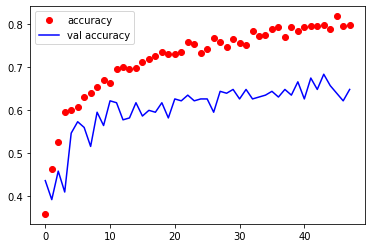

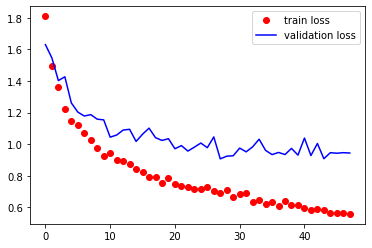

In [17]:

import matplotlib.pyplot as plt

train_acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

plt.plot(train_acc,'bo', color='r', label='accuracy')
plt.plot(val_acc,'b', color='b', label='val accuracy')
plt.legend()
plt.show()


train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(train_loss,'bo', color='r', label='train loss')
plt.plot(val_loss,'b', color='b', label='validation loss')
plt.legend()
plt.show()

{0: 'soju', 1: 'soda', 2: 'beer', 3: 'wine', 4: 'vita', 5: 'glass', 6: 'colorless_soju', 7: 'colorless_bottle', 8: 'color_bottle'}
Confusion Matrix


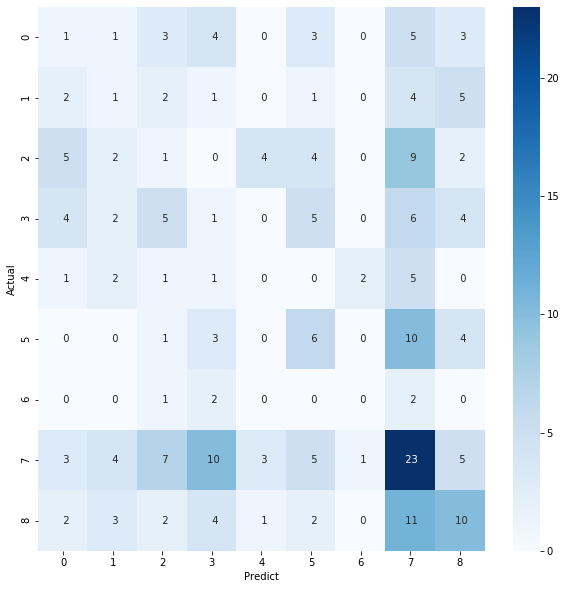

In [18]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns 



model_path = './model/recycle_vgg.h5'


vgg_model = tf.keras.models.load_model(model_path)
category_list = list(category_csv['bottle_name'])


label_dict_reverse = dict(category_csv[['bottle_id','bottle_name']].values)
print(label_dict_reverse)

#Confution Matrix and Classification Report
Y_pred = vgg_model.predict_generator(validationGen, 227//64+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
# display(confusion_matrix(validationGen.classes, y_pred))



fig, ax = plt.subplots(figsize=(10,10))  # inch단위로 그림의 크기
sns.heatmap(
    confusion_matrix(validationGen.classes, y_pred),
    annot = True, # 숫자표현
    cbar = True,  # color bar 
    fmt = '3d',    # 정수표현     
    cmap = 'Blues', # color 색상
    ax = ax       # 그래프로 사용할 subplot
)
ax.set_xlabel('Predict')
ax.set_ylabel('Actual')
plt.show()